#  XPCS   SAXS Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [2]:
%matplotlib notebook
#%matplotlib inline


In [3]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

/XF11ID/analysis/Analysis_Pipelines/Develop


In [5]:
%run chx_generic_functions.py
%run XPCS_SAXS.py
%run Two_Time_Correlation_Function.py
#%run speckle.py

In [6]:
plt.rcParams.update({'figure.max_open_warning': 0})

# Startup Setting

## Detector

In [15]:
#detectors = ['eiger4m_single_image', 'eiger1m_single_image', 'eiger4m_image', 'eiger1m_image']
detector = 'eiger4m_single_image'  #for after 2015-12 data
detector = 'eiger_4M_cam_img_image_lightfield'  #for before 2015-12 data

In [28]:
path = '/home/yuzhang/Analysis/2016_1/Results/'

dt =datetime.now()
CurTime = '%s%02d%02d-%02d%02d' % (dt.year, dt.month, dt.day,dt.hour,dt.minute)


mask_name =  'ee6975a1-9161_mask.npy'



### Get the image series and metadata from the uid

In [32]:
uid='ee6975a1-9161'   #1% wt PEG
sn = 'SiO2_Colloidal'


In [29]:
if not os.path.exists(path+'%s'%(sn)):
    os.mkdir( path + sn )
    path = path + sn + '/'
print ("The analysis results will be saved in : %s"%path)    

The analysis results will be saved in : /home/yuzhang/Analysis/2016_1/Results/SiO2_Colloidal/


In [33]:
get_sid_filenames(db[uid])

(1224,
 'ee6975a1-9161-4315-9929-4db995a91b5c',
 ['/XF11ID/data/2015/11/23/5f7b93e2-71ef-41b0-9c2c_138'])

In [16]:
imgs = load_data( uid, detector  )
md = imgs.md

hdf5 path = /XF11ID/data/2015/11/23/5f7b93e2-71ef-41b0-9c2c_138_master.h5


In [17]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

In [59]:
sampling = 100

In [34]:
uid = uid[:8] +'--%s_'%sn
print (uid)

ee6975a1--SiO2_Colloidal_


## Overwrite some metadata due to wrong input

In [20]:
md

{'beam_center_x': 852.0,
 'beam_center_y': 1830.0,
 'count_time': 0.0049899998,
 'detector_distance': 4.8400002,
 'frame_time': 0.0049999999,
 'framerate': 200.00000447034847,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [48]:
dpix =   0.075        #in eiger 4M, mm
Ldet = md['detector_distance'] *1000     #4840 in mm
lambda_  = md['incident_wavelength']  #1.4250998
timeperframe=md['frame_time']
#center = md['beam_center_x'], md['beam_center_y'] 

center = [ 846,1830]  # center of the speckle pattern


center=[center[1], center[0]]
print (center)

[1830, 846]


In [49]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
                 timeperframe=timeperframe, center=center)

In [50]:
setup_pargs

{'Ldet': 4840.0001525878906,
 'center': [1830, 846],
 'dpix': 0.075,
 'lambda_': 1.3776,
 'timeperframe': 0.0049999999,
 'uid': 'ee6975a1--SiO2_Colloidal_'}

## Load Mask 

<IPython.core.display.Javascript object>


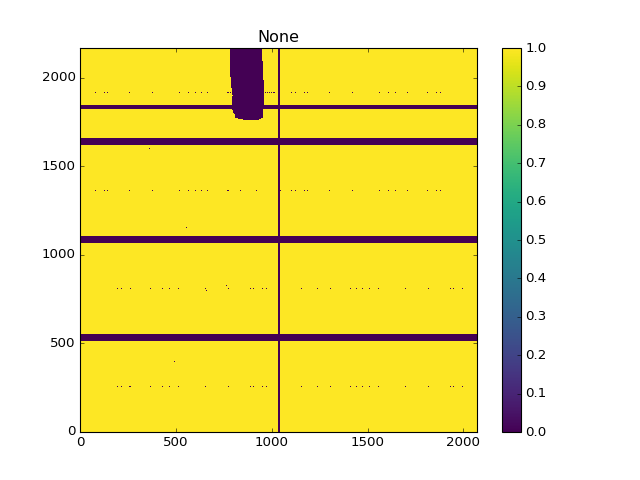

In [26]:
mask = load_mask( path, mask_name, plot_ =  True )

## Apply Mask to time-series

In [36]:
imgsa = apply_mask( imgs, mask )

<IPython.core.display.Javascript object>


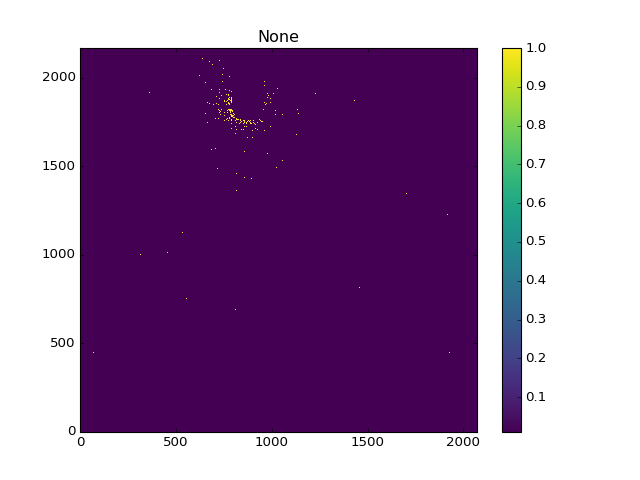

In [38]:
show_img( imgsa[0], vmin=.01, vmax=1) 

In [269]:
#show_img( imgsa[0],  norm= LogNorm(vmin=1, vmax=20)) 

## Check shutter open frame and get good time series

In [39]:
good_start = check_shutter_open( imgsa,  min_inten=5, time_edge = [0,10], plot_ = False )

The first frame with open shutter is : 0


In [40]:
good_series = apply_mask( imgs[good_start:], mask )
Nimg = len(good_series)

## Find bad frames by checking total scattering intensity 

<IPython.core.display.Javascript object>


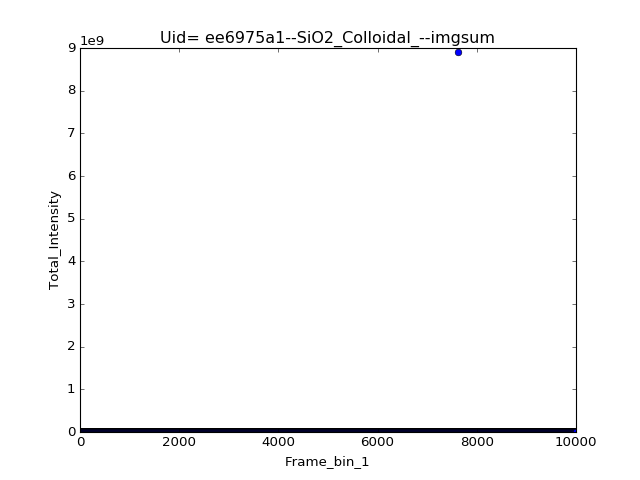

No bad frames are involved.


In [66]:
imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = 1, 
                                bad_pixel_threshold=1e8,  plot_ = True, uid=uid)

In [100]:
bad_frame_list = np.array( [7629] )  #we know this is a bad frame 

## Get intensity average image

<IPython.core.display.Javascript object>


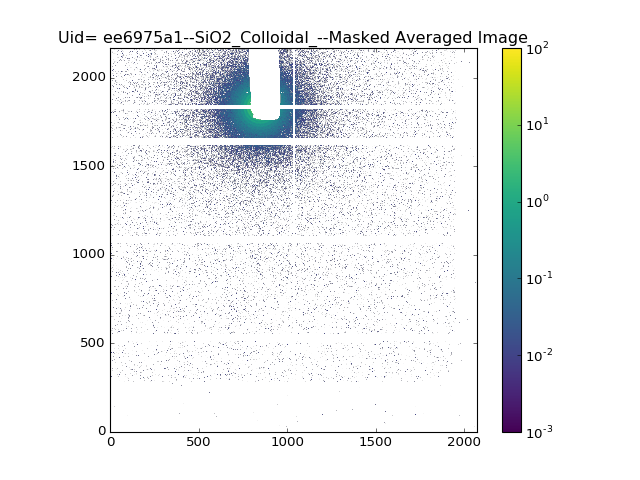

In [67]:
avg_img =  get_avg_img( good_series, sampling = sampling, plot_ = True, uid =uid)

In [274]:
#avg_img =  get_avg_img( good_series, sampling = 50, plot_ = True, uid =uid)

<IPython.core.display.Javascript object>


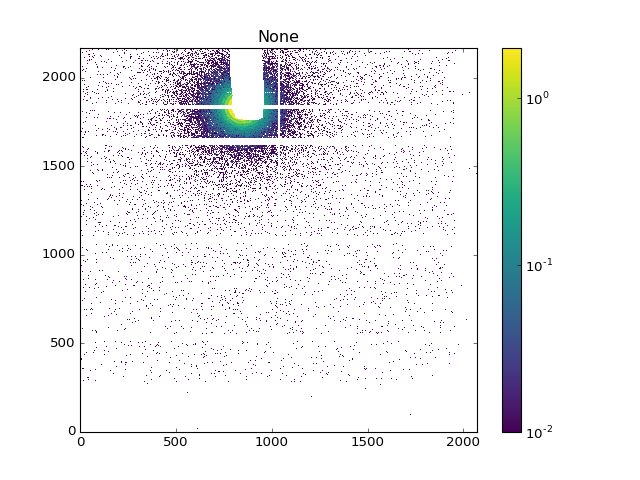

In [62]:
show_img( avg_img,  vmin=.01, vmax=2, logs=True )

## Get circular average 

In [63]:
hmask = create_hot_pixel_mask( avg_img, 1e8)

<IPython.core.display.Javascript object>


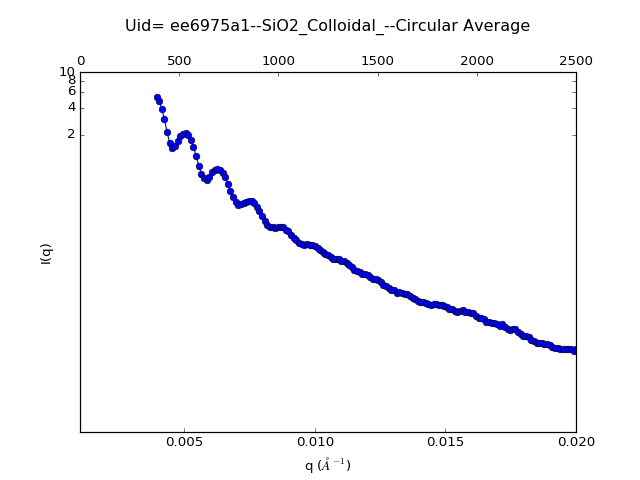

In [87]:
qp, iq, q = get_circular_average( avg_img, mask*hmask, pargs=setup_pargs, 
                                 plot_ = True, plot_qinpixel=False, xlim=[0.001,.02], ylim = [0.001, 10])

In [88]:
#plot1D( x = q, y = iq, logy=True, xlim = [0.001, 0.02 ], ylim = [0.001, 10])

In [278]:
#214/161

## Create ring mask defined by  inner_radius, outer_radius, width, num_rings

In [69]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=58, outer_radius = 120,
                                         width = 2, num_rings = 6, pargs=setup_pargs   )

<IPython.core.display.Javascript object>


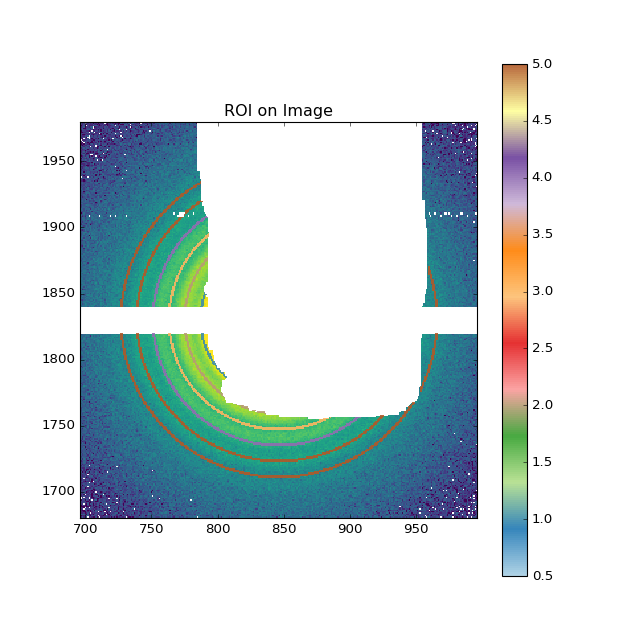

In [162]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=150, alpha=.9)

<IPython.core.display.Javascript object>


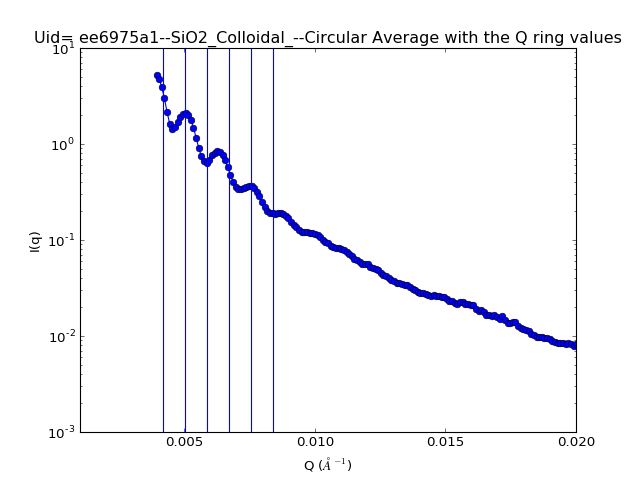

In [91]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.001,.02], ylim = [0.001, 10])

In [281]:
#q_ring_center

## Check one ring intensity 

<IPython.core.display.Javascript object>


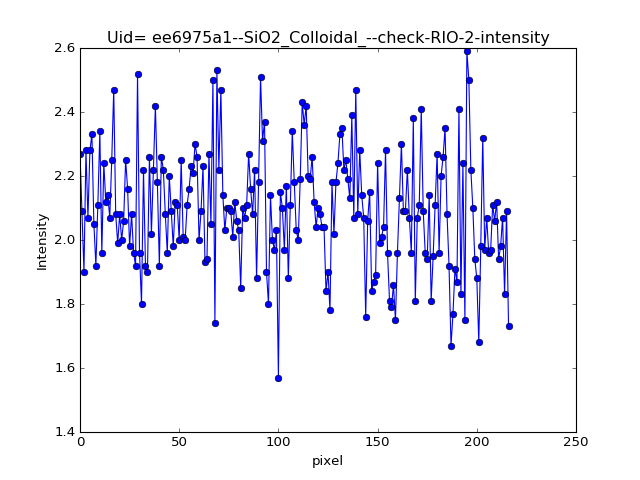

In [80]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 2, uid =uid )

## Check beam damage
* check time~I(q)
* check mean intensity of each ring as a function of time

In [84]:
time_edge = create_time_slice( N=Nimg, slice_num= 3, slice_width=10, edges = None )

<IPython.core.display.Javascript object>


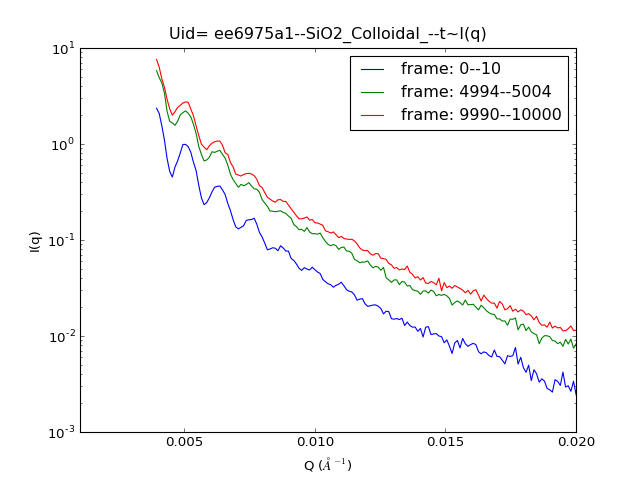

In [93]:
qp, iqs, q = get_t_iq( good_series, time_edge, mask*hmask, pargs=setup_pargs, nx=1500, 
                      plot_ = True,  xlim=[0.001,0.02], ylim = [0.001, 10])

<IPython.core.display.Javascript object>


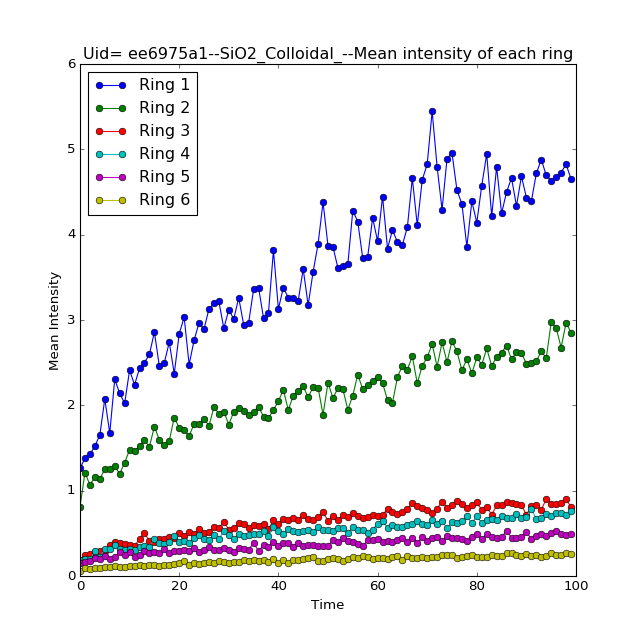

In [97]:
mean_int_sets = get_each_ring_mean_intensity(good_series, ring_mask, sampling = sampling,
                                timeperframe = md['frame_time'], plot_ = True, uid = uid  )

In [96]:
%run XPCS_SAXS.py

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

In [101]:
bad_image_process = False
if  len(bad_frame_list):
    bad_image_process = True
bad_image_process 

True

In [102]:
t0 = time.time()
g2, lag_steps  =cal_g2( good_series, ring_mask, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--12--
10000 frames will be processed...
Bad Frames involved!
G2 calculation DONE!
Total time: 8.11 min


In [154]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=path, uid=uid        )

### Plot the one time correlation functions

<IPython.core.display.Javascript object>


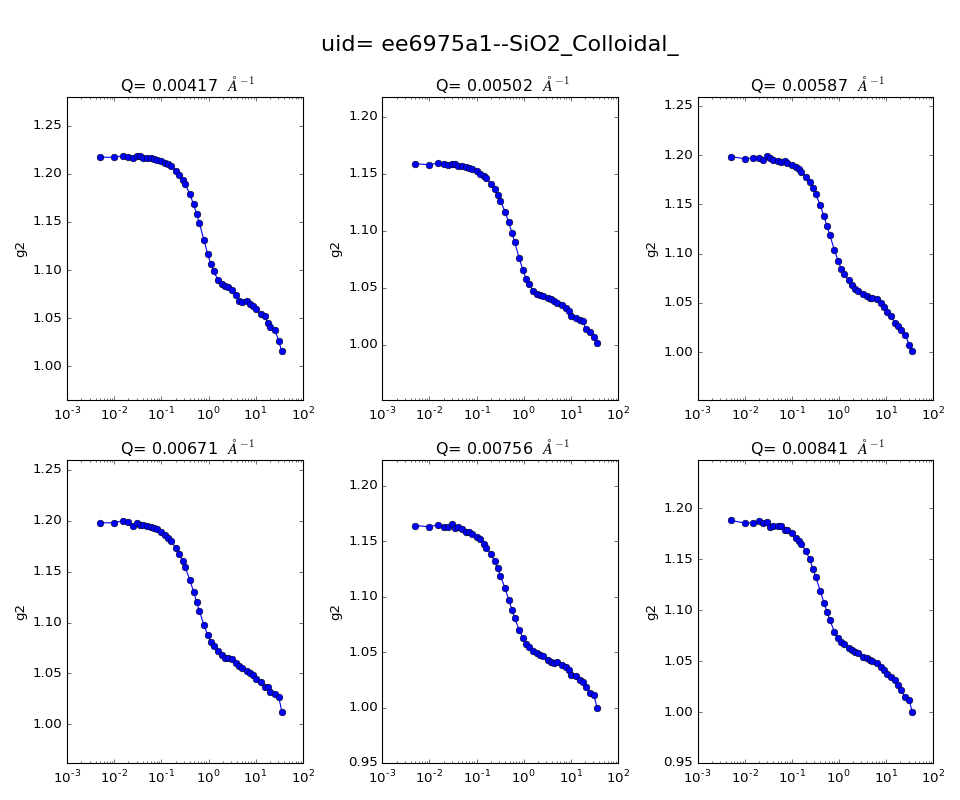

In [109]:
plot_saxs_g2( g2, taus, vlim=[0.95, 1.05], res_pargs=res_pargs)      
#plot_saxs_g2( g2, taus, q_ring_center = q_ring_center, vlim=[.99, 1.01], uid=uid, path=path )

In [107]:
save_saxs_g2(  g2, res_pargs )

The g2 of uid= ee6975a1--SiO2_Colloidal_ is saved in /home/yuzhang/Analysis/2016_1/Results/SiO2_Colloidal/ with filename as g2-ee6975a1--SiO2_Colloidal_-20160510-1906-.csv


# Fit g2

In [110]:
fit = True

<IPython.core.display.Javascript object>


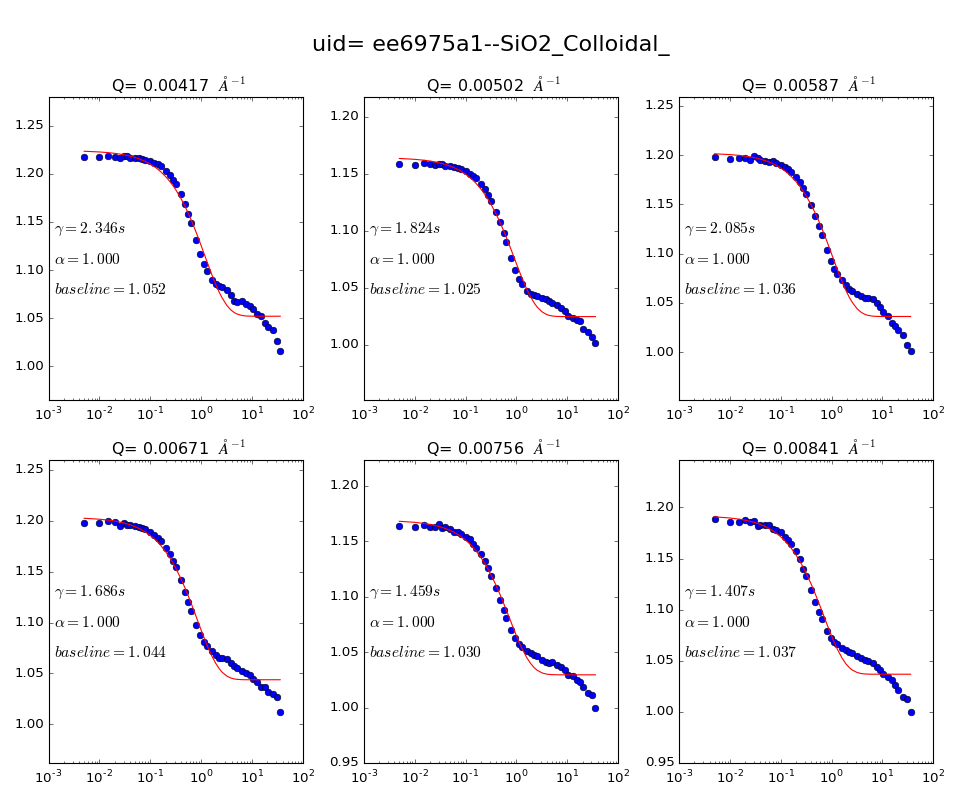

In [148]:
if fit:
    result = fit_saxs_g2( g2, res_pargs, function = 'simple')
    

The fitted diffusion coefficient D0 is:  5.20E+03   A^2S-1


<IPython.core.display.Javascript object>


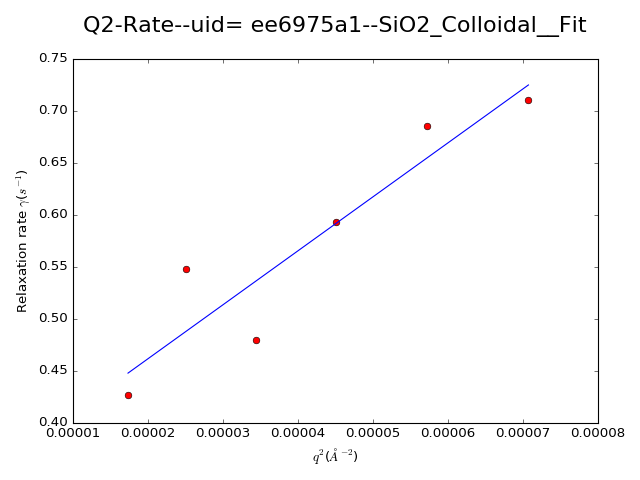

array([  5.19943204e+03,   3.57229063e-01])

In [149]:
fit_q2_rate(  q_ring_center**2, result['rate'], uid=uid, path=path )

# For two-time

In [113]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

/XF11ID/analysis/Analysis_Pipelines/Develop


In [114]:
run_two_time = True

In [115]:
if run_two_time:
    #cd /XF11ID/analysis/Analysis_Pipelines/Develop/
    #%run develop.py
    %run Two_Time_Correlation_Function.py
    qind, pixelist = roi.extract_label_indices(   ring_mask  )
    noqs = len( np.unique(qind) )
    nopr = np.bincount(qind, minlength=(noqs+1))[1:] 
    t0 = time.time()
    data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()
    run_time(t0)
    g12b = auto_two_Array( good_series, ring_mask, data_pixel = data_pixel ) 

Total time: 7.57 min
Total time: 0.33 min


<IPython.core.display.Javascript object>


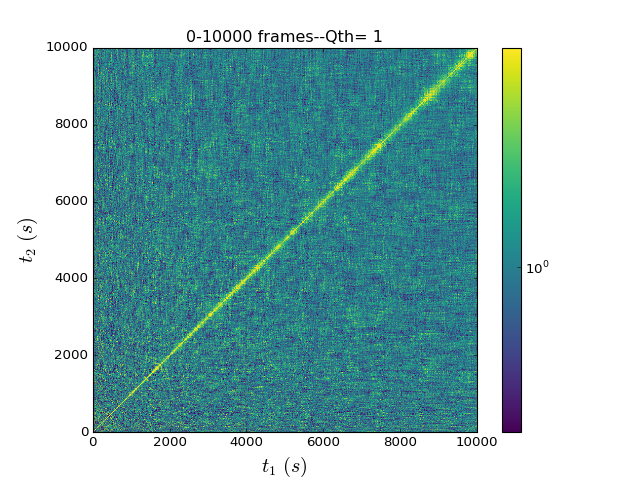

In [163]:
if run_two_time:
    show_C12(g12b, q_ind= 1, N1=0, N2= 10000, vmin=.9, vmax=1.15,  )

#a waterfall

In [179]:
qmax_int = 2
pixelist_qi =  np.where( qind == qmax_int)[0]         
kymo = data_pixel[:,pixelist_qi].T

<IPython.core.display.Javascript object>


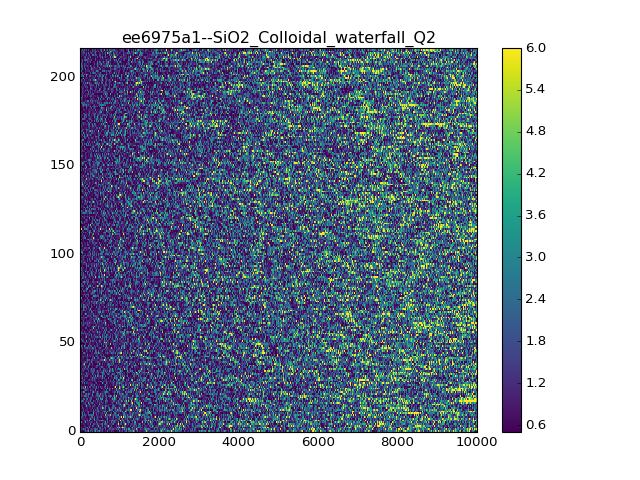

In [180]:
show_img( kymo, vmin=.5, vmax= 6 ,aspect='auto', 
         image_name =uid +'waterfall_Q2', path=path )

In [131]:
if run_two_time:
    g2b = get_one_time_from_two_time(g12b)

<IPython.core.display.Javascript object>


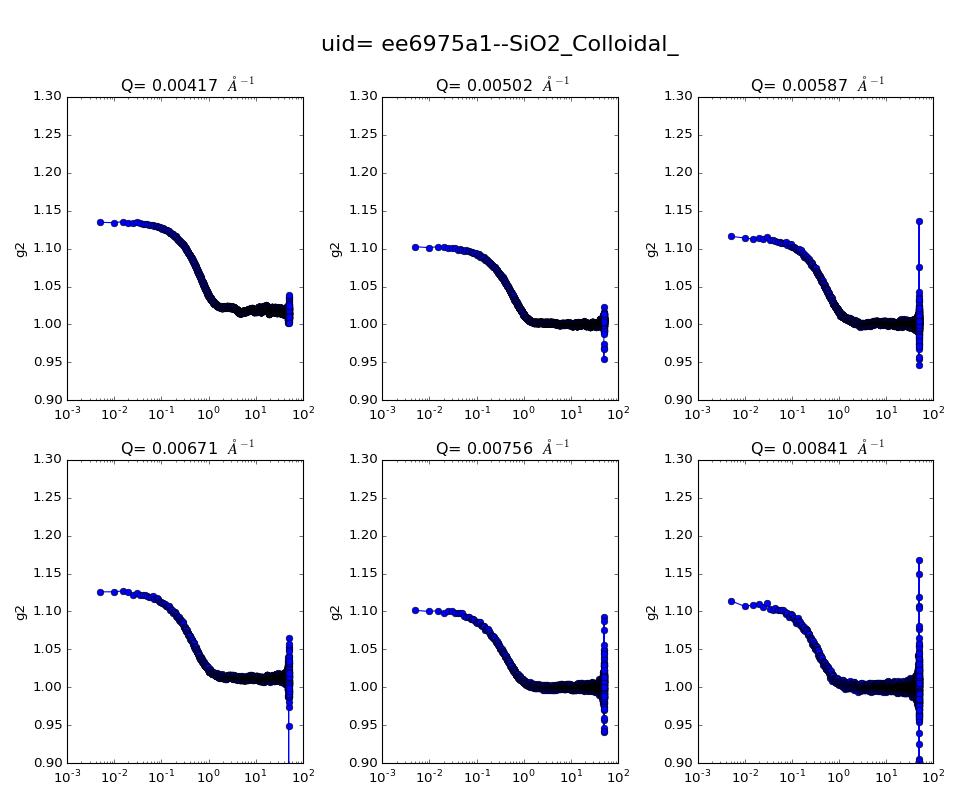

In [133]:
plot_saxs_g2( g2b, taus= np.arange( g2b.shape[0]) *timeperframe, ylim=[0.9, 1.3],
             q_ring_center = q_ring_center, vlim=[.99, 1.01], uid = uid, path=path )

In [137]:
taus2 = np.arange( g2b.shape[0]) *timeperframe
res_pargs2 = dict(taus=taus2, q_ring_center=q_ring_center, path=path, uid=uid        )

<IPython.core.display.Javascript object>


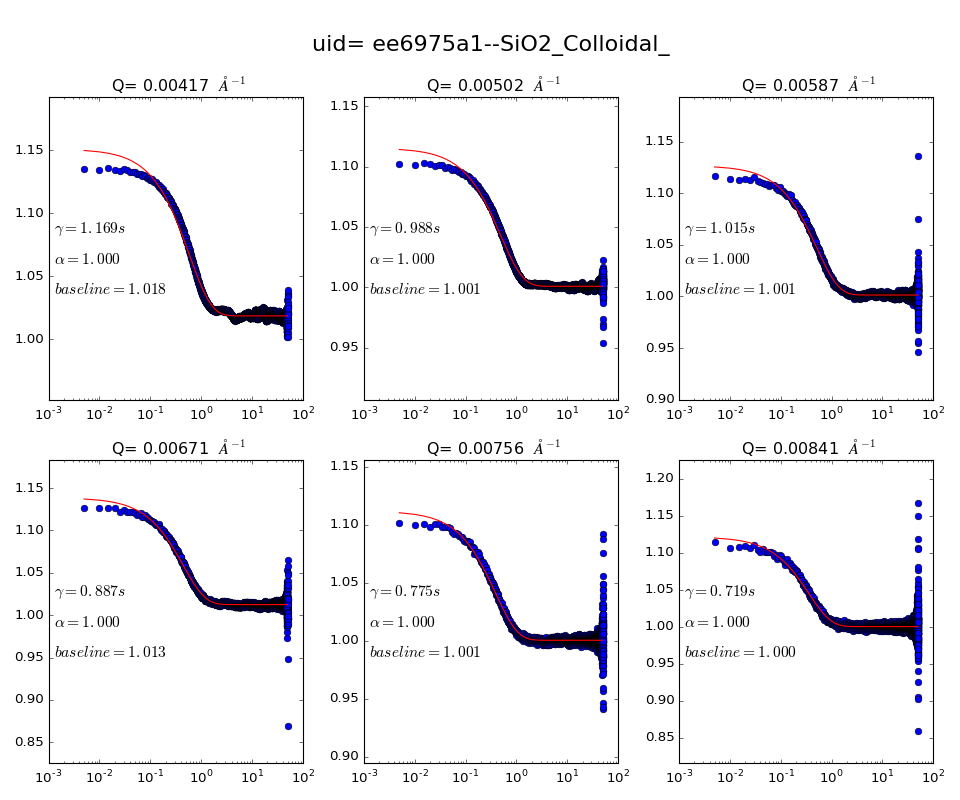

In [150]:
result2 = fit_saxs_g2( g2b, res_pargs2, function = 'simple')

The fitted diffusion coefficient D0 is:  9.80E+03   A^2S-1


<IPython.core.display.Javascript object>


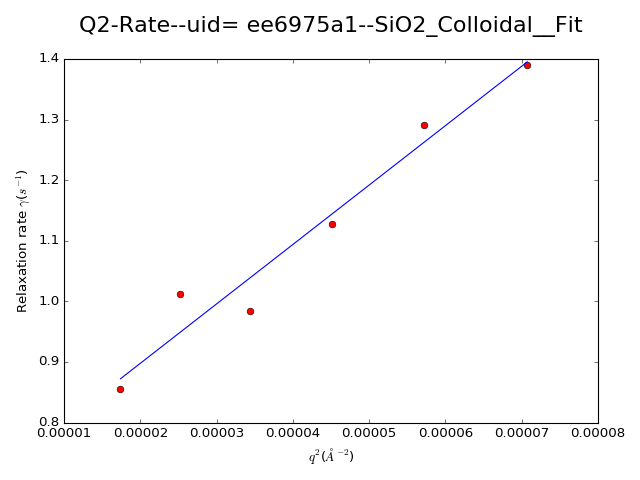

array([  9.80495902e+03,   7.01730428e-01])

In [151]:
fit_q2_rate(  q_ring_center**2, result2['rate'], uid=uid, path=path )

In [76]:
#result = fit_saxs_g2( g2, res_pargs, function = 'simple')

In [77]:
#result = fit_saxs_g2( g2, res_pargs, function = 'simple')

<IPython.core.display.Javascript object>


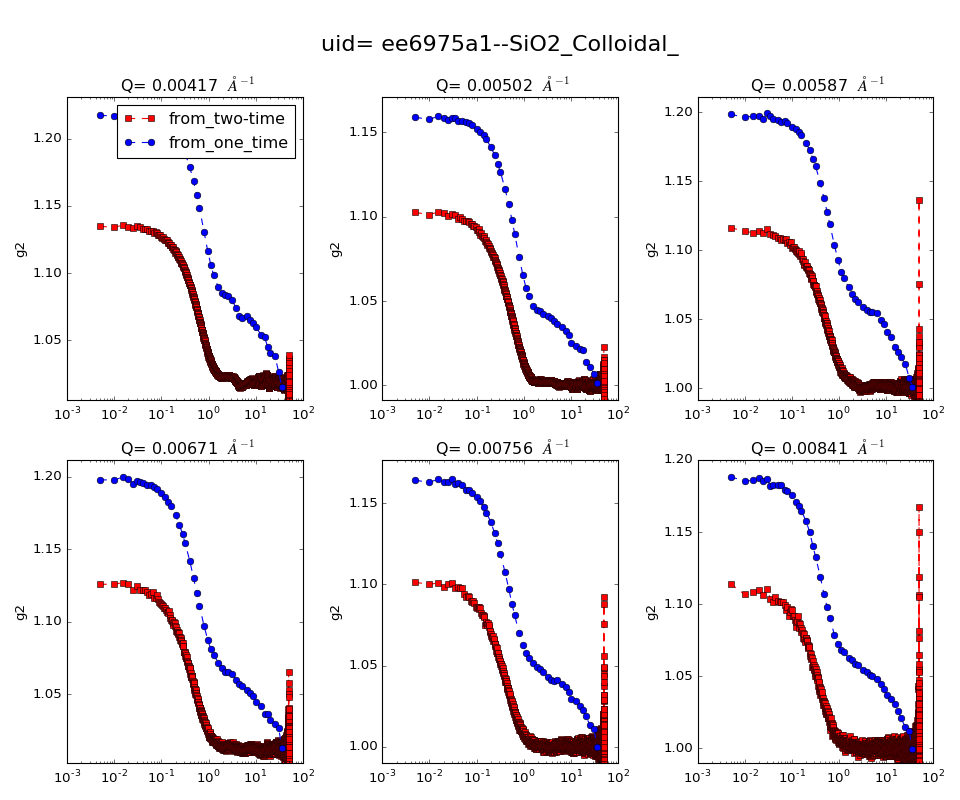

In [157]:
if run_two_time:
    plot_saxs_two_g2( g2, taus, 
                 g2b, np.arange( g2b.shape[0]) *timeperframe,
                 q_ring_center = q_ring_center, vlim=[.99, 1.01], uid=uid, path=path )

In [79]:
#plot_saxs_g2( g2, taus, q_ring_center = q_ring_center, vlim=[.99, 1.01], uid=uid )


# The End!